In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')

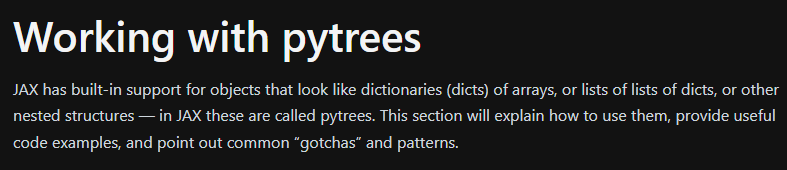

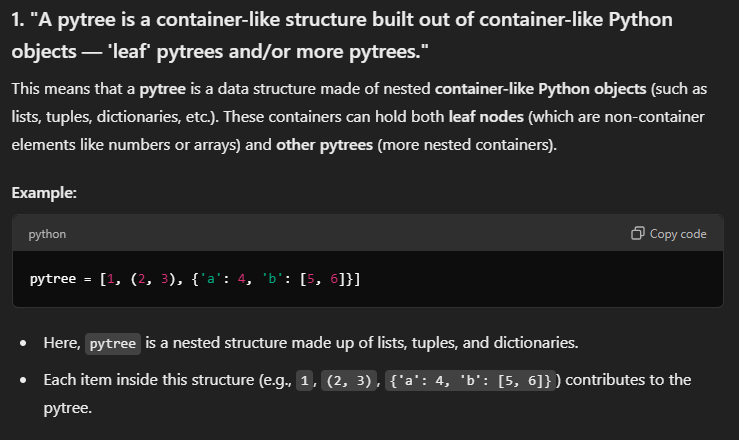

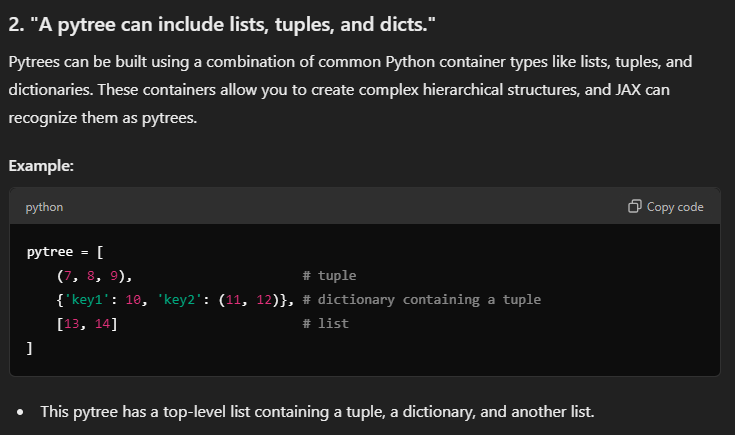

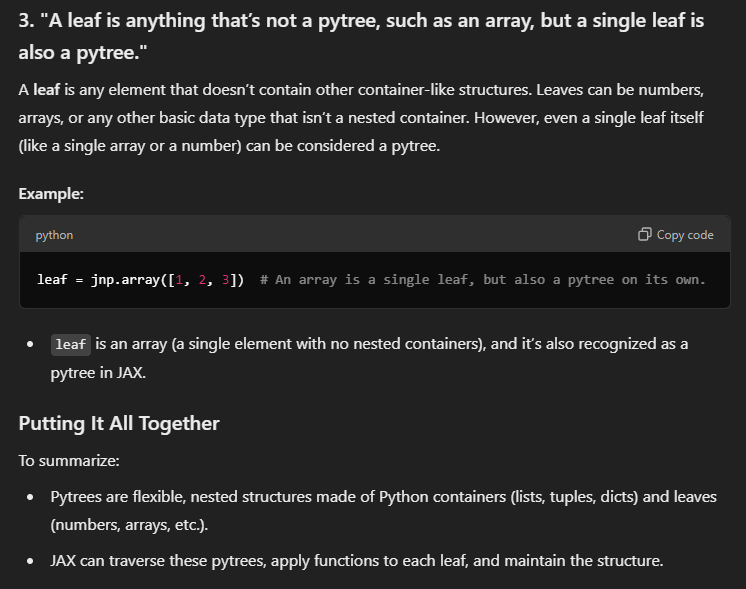

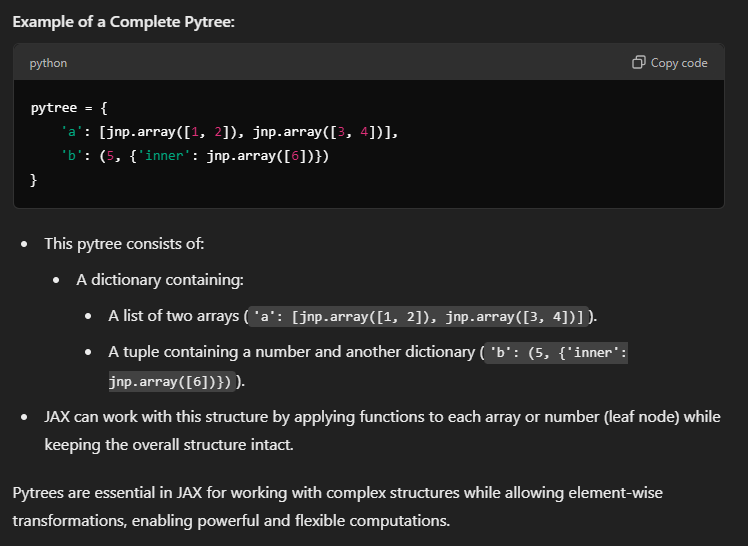

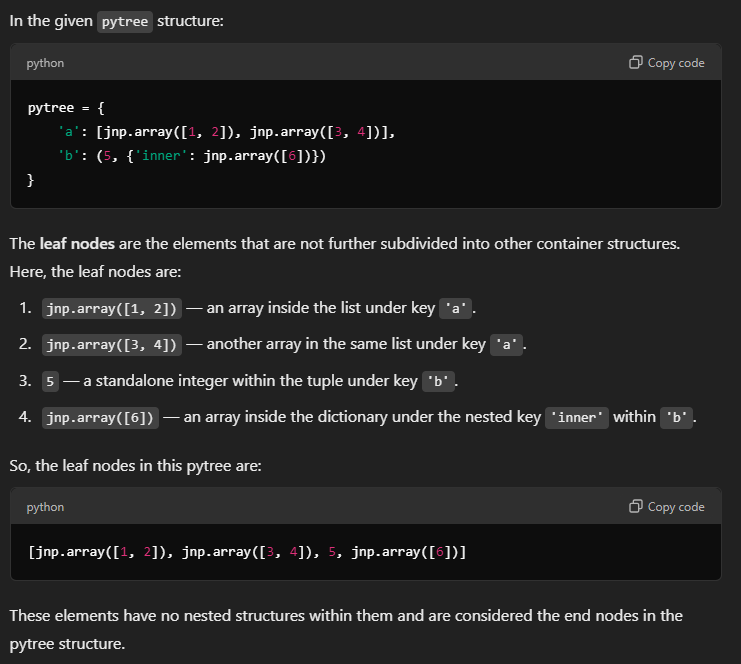

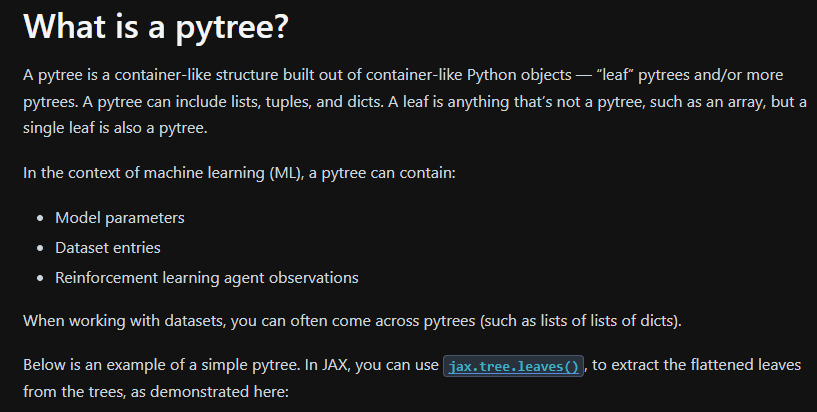

In [2]:
import jax
import jax.numpy as jnp

example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

# Print how many leaves the pytrees have.
for pytree in example_trees:
  # This `jax.tree.leaves()` method extracts the flattened leaves from the pytrees.
  leaves = jax.tree.leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x000002C9049B3CB0>] has 3 leaves: [1, 'a', <object object at 0x000002C9049B3CB0>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
Array([1, 2, 3], dtype=int32)                 has 1 leaves: [Array([1, 2, 3], dtype=int32)]


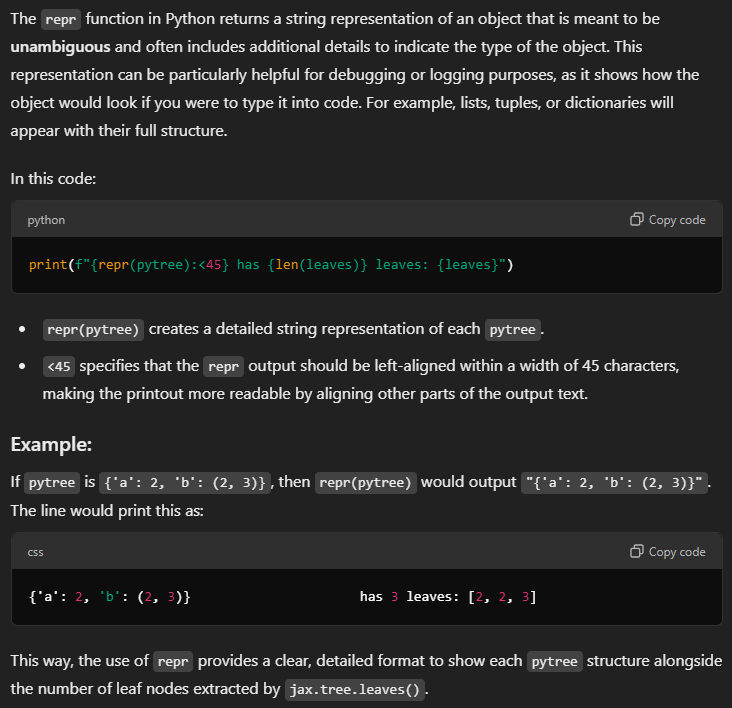

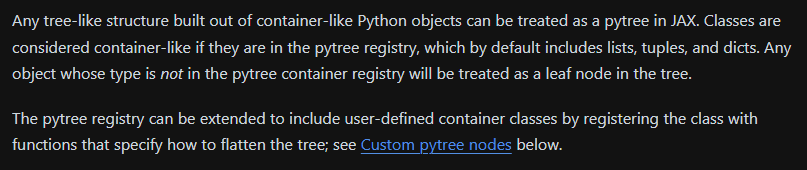

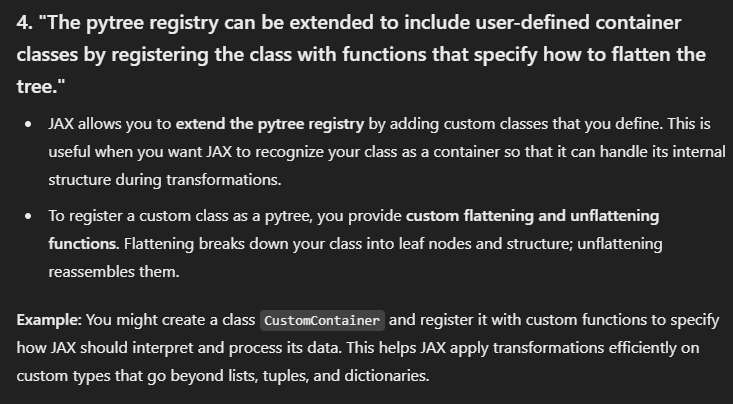

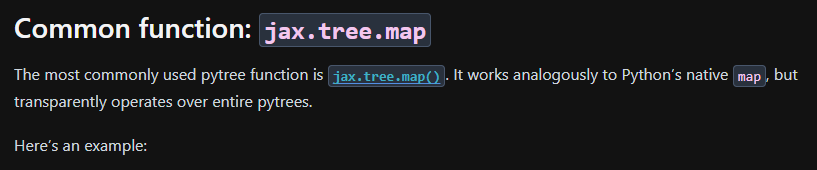

In [3]:
list_of_lists = [
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]

jax.tree.map(lambda x: x*2, list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

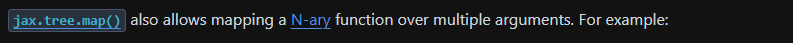

In [4]:
another_list_of_lists = list_of_lists
jax.tree.map(lambda x, y: x+y, list_of_lists, another_list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

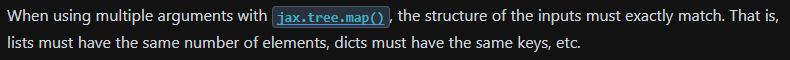

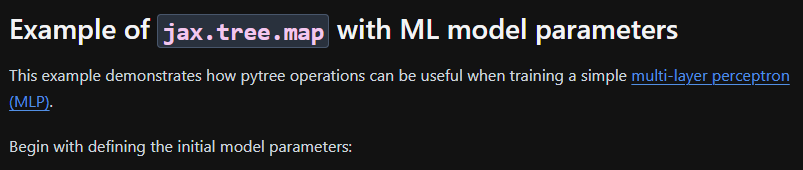

In [7]:
import numpy as np

def init_mlp_params(layer_widths):
  params = []
#   print(f'This is layer_widths[:-1] {layer_widths[:-1]}')
#   print(f'This is layer_widths[1:] {layer_widths[1:]}')
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,))
            )
    )
  return params

params = init_mlp_params([1, 128, 128, 1])

This is layer_widths[:-1] [1, 128, 128]
This is layer_widths[1:] [128, 128, 1]


In [6]:
jax.tree.map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

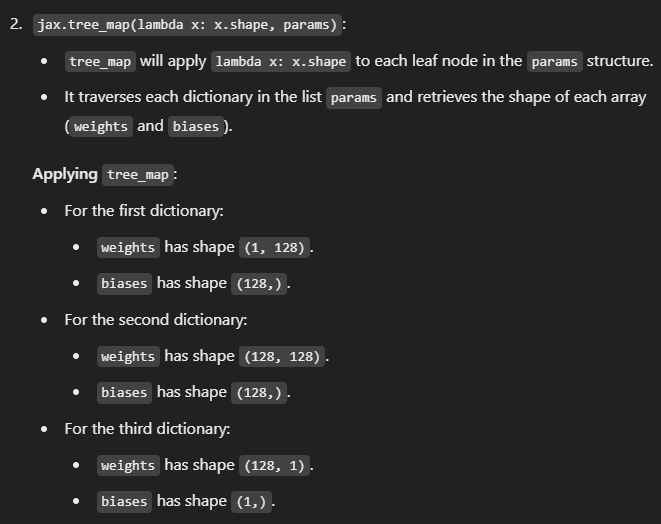

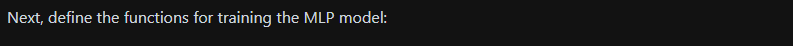

In [ ]:
# Define the forward pass.
def forward(params, x):
    *hidden, last = params
    for layer in hidden:
        x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['biases']

# Define the loss function.
def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)

# Set the learning rate.
LEARNING_RATE = 0.0001

# Using the stochastic gradient descent, define the parameter update function.
# Apply `@jax.jit` for JIT compilation (speed).
@jax.jit
def update(params, x, y):
    # Calculate the gradients with `jax.grad`.
    grads = jax.grad(loss_fn)(params, x, y)
    # Note that `grads` is a pytree with the same structure as `params`.
    # `jax.grad` is one of many JAX functions that has
    # built-in support for pytrees.
    # This is useful - you can apply the SGD update using JAX pytree utilities.
    return jax.tree_map(
        lambda p, g: p - LEARNING_RATE * g, params, grads
    )


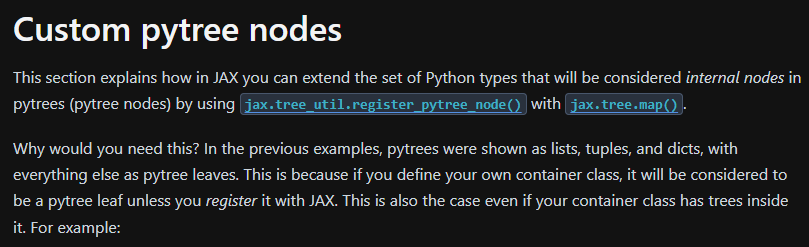

In [16]:
class Special(object):
  def __init__(self, x, y):
    self.x = x
    self.y = y

jax.tree.leaves([
    Special(0, 1),
    Special(2, 4),
])
#Remember, a single leaf is also a pytree

[<__main__.Special at 0x2c925600990>, <__main__.Special at 0x2c925143e50>]

In [17]:
jax.tree.map(lambda x: x + 1,
  [
    Special(0, 1),
    Special(2, 4)
  ])

TypeError: unsupported operand type(s) for +: 'Special' and 'int'

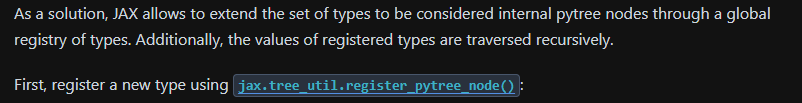

In [18]:
from jax.tree_util import register_pytree_node

class RegisteredSpecial(Special):
  def __repr__(self):
    return "RegisteredSpecial(x={}, y={})".format(self.x, self.y)

def special_flatten(v):
  """Specifies a flattening recipe.

  Params:
    v: The value of the registered type to flatten.
  Returns:
    A pair of an iterable with the children to be flattened recursively,
    and some opaque auxiliary data to pass back to the unflattening recipe.
    The auxiliary data is stored in the treedef for use during unflattening.
    The auxiliary data could be used, for example, for dictionary keys.
  """
  children = (v.x, v.y)
  aux_data = None
  return (children, aux_data)

def special_unflatten(aux_data, children):
  """Specifies an unflattening recipe.

  Params:
    aux_data: The opaque data that was specified during flattening of the
      current tree definition.
    children: The unflattened children

  Returns:
    A reconstructed object of the registered type, using the specified
    children and auxiliary data.
  """
  return RegisteredSpecial(*children)

# Global registration
register_pytree_node(
    RegisteredSpecial,
    special_flatten,    # Instruct JAX what are the children nodes.
    special_unflatten   # Instruct JAX how to pack back into a `RegisteredSpecial`.
)

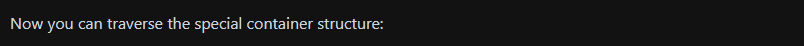

In [19]:
jax.tree.map(lambda x: x + 1,
  [
   RegisteredSpecial(0, 1),
   RegisteredSpecial(2, 4),
  ])

[RegisteredSpecial(x=1, y=2), RegisteredSpecial(x=3, y=5)]

In [25]:
jax.tree.leaves([RegisteredSpecial(1, 2),RegisteredSpecial(0, 1)])

[1, 2, 0, 1]

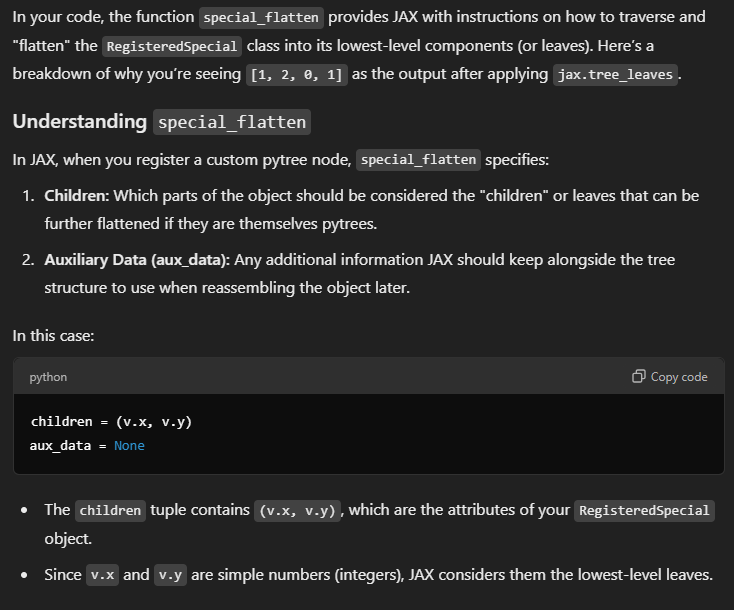

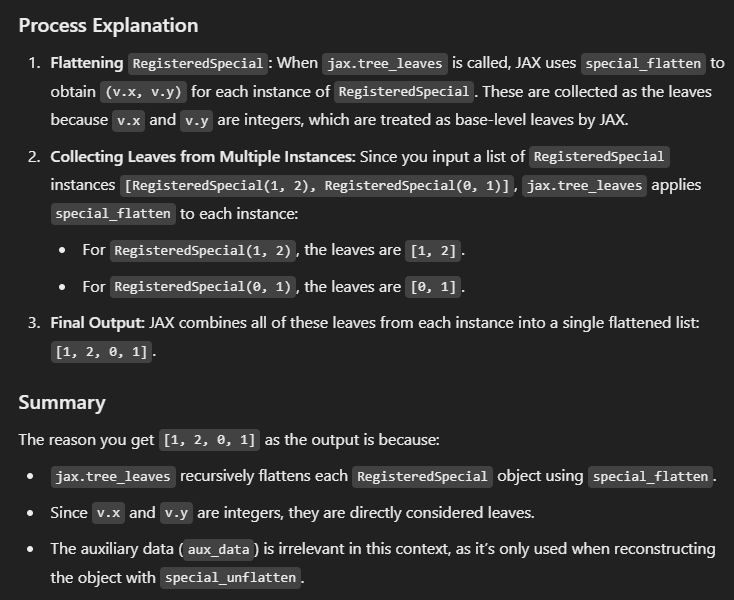

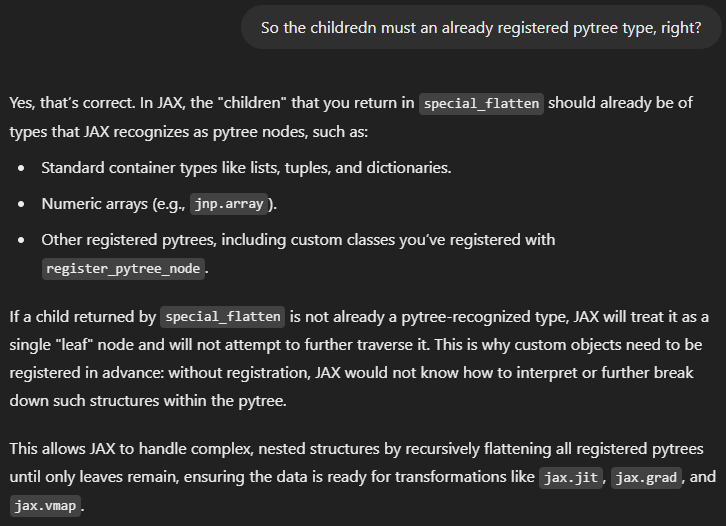

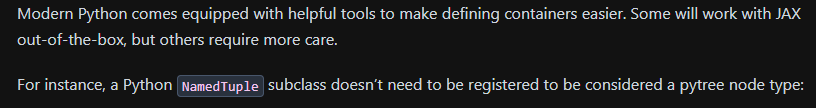

In [26]:
from typing import NamedTuple, Any

class MyOtherContainer(NamedTuple):
  name: str
  a: Any
  b: Any
  c: Any

# NamedTuple subclasses are handled as pytree nodes, so
# this will work out-of-the-box.
jax.tree.leaves([
    MyOtherContainer('Alice', 1, 2, 3),
    MyOtherContainer('Bob', 4, 5, 6)
])

['Alice', 1, 2, 3, 'Bob', 4, 5, 6]

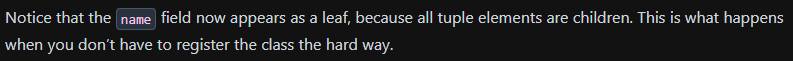

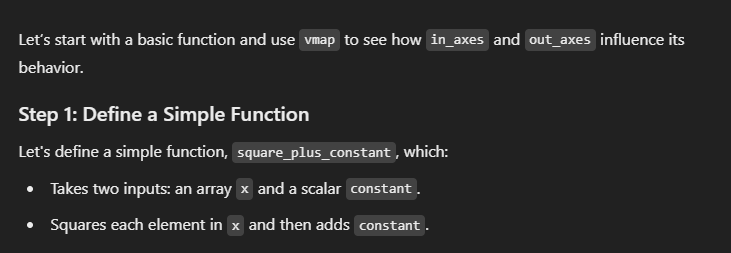

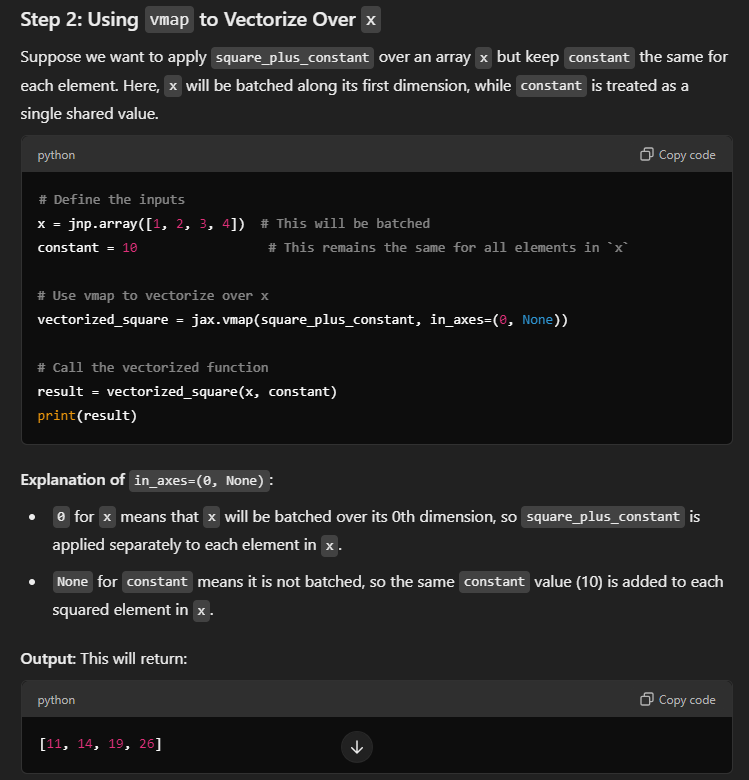

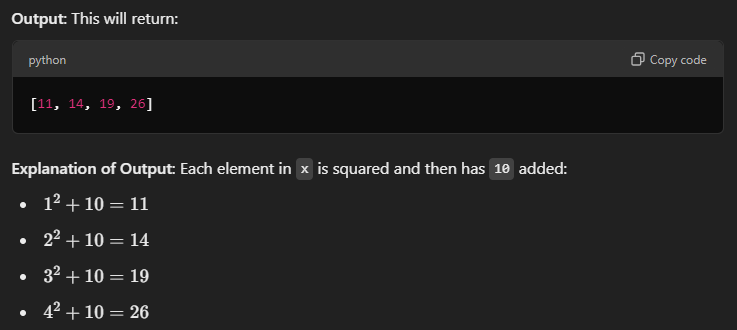

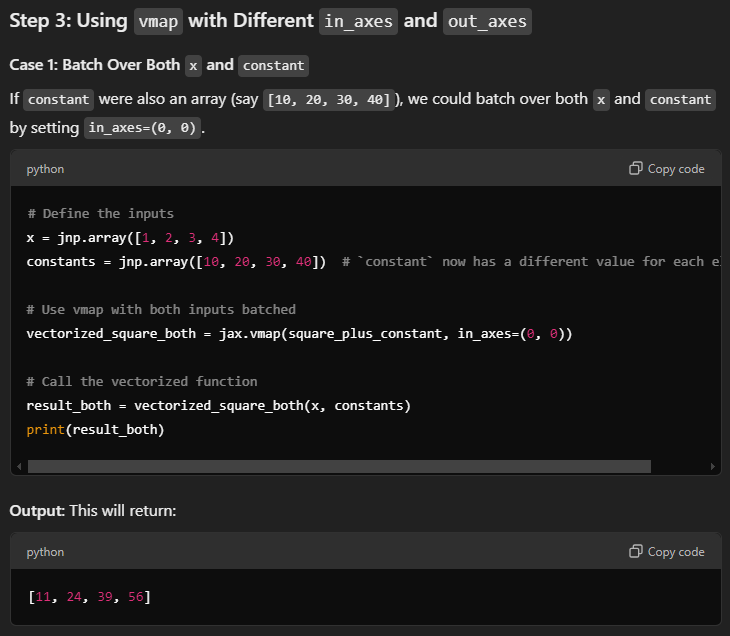

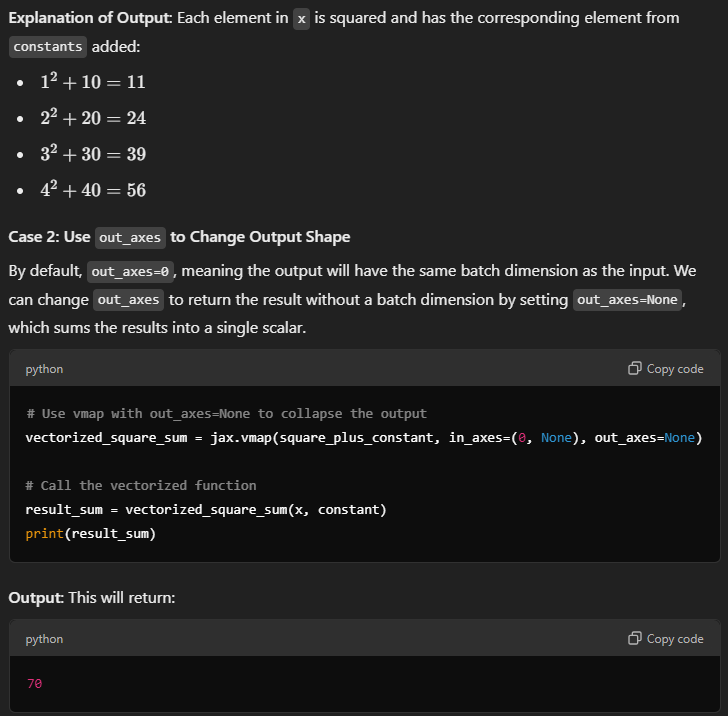

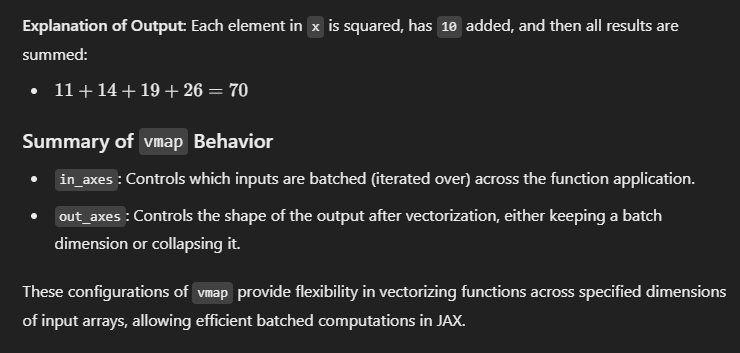

In [27]:
import jax
import jax.numpy as jnp

def square_plus_constant(x, constant):
    return x ** 2 + constant

In [32]:
# Define the inputs
x = jnp.array([1, 2, 3, 4])  # This will be batched
constant = 10                 # This remains the same for all elements in `x`

# Use vmap to vectorize over x
vectorized_square = jax.vmap(square_plus_constant, in_axes=(0, None), out_axes=0)

# Call the vectorized function
result = vectorized_square(x, constant)
print(result)

[11 14 19 26]


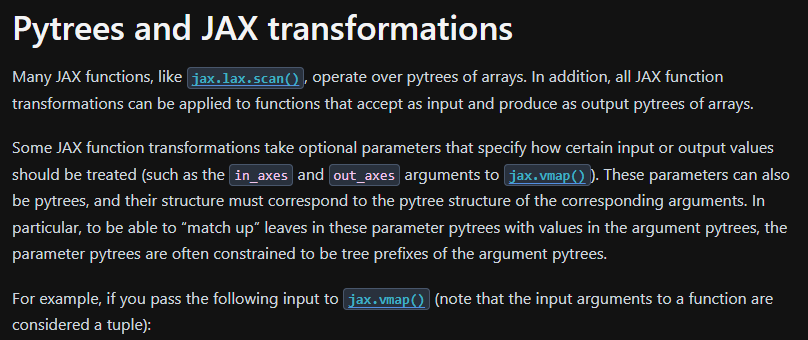

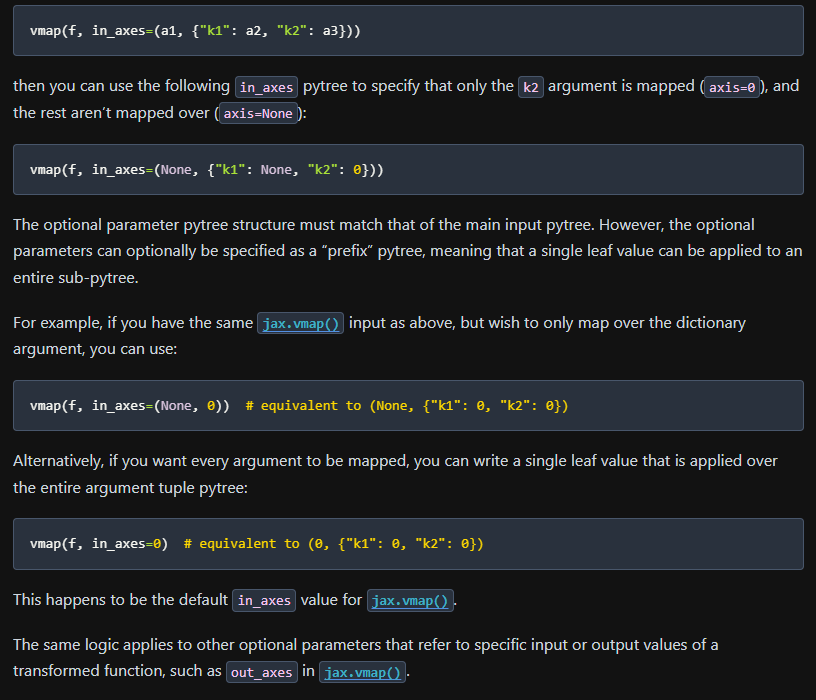

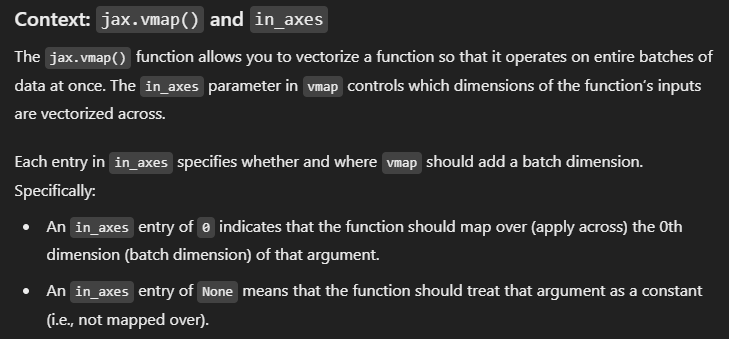

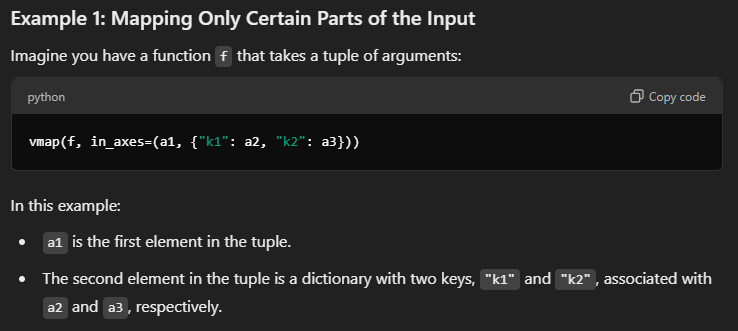

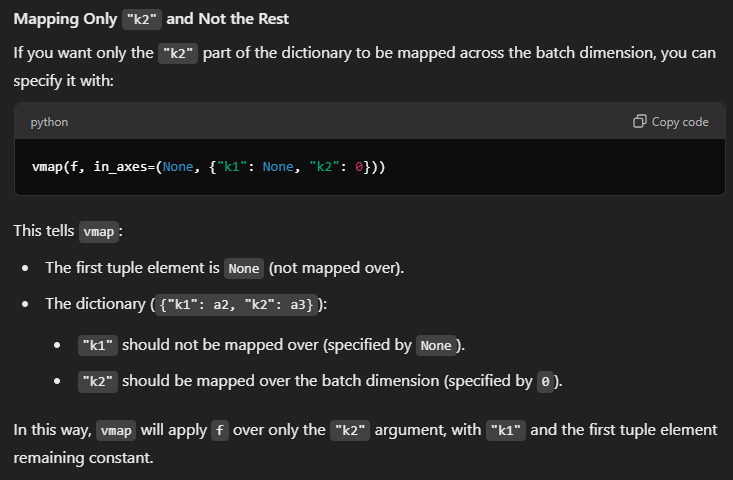

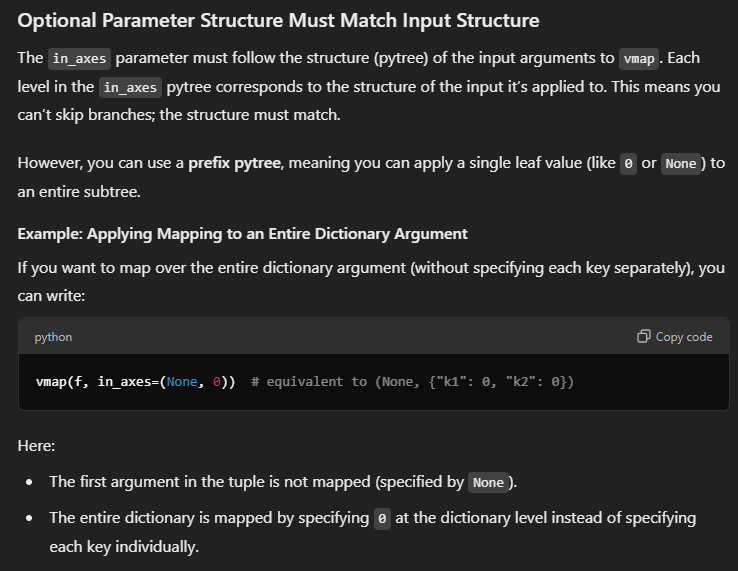

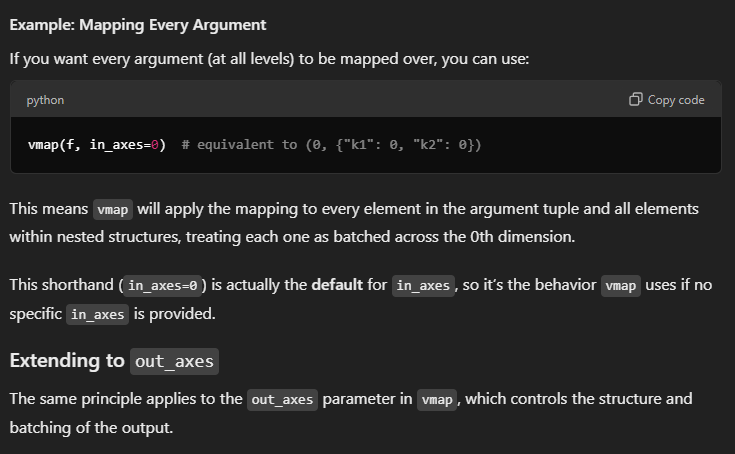

In [33]:
vmap(f, in_axes=(a1, {"k1": a2, "k2": a3}))

NameError: name 'vmap' is not defined

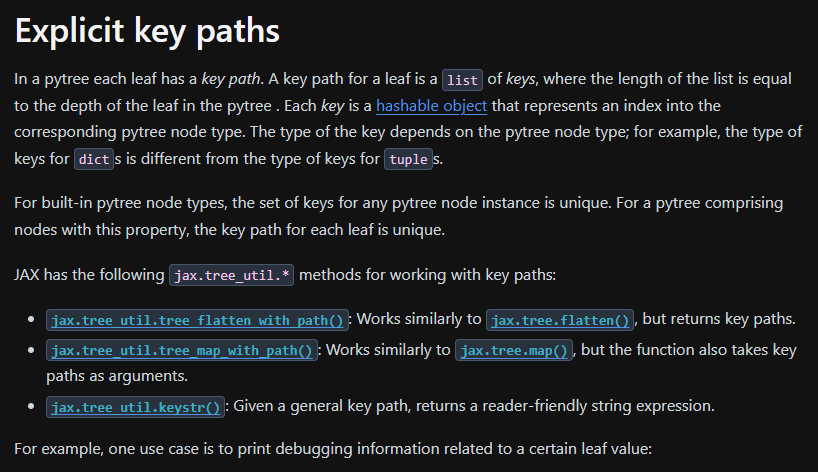

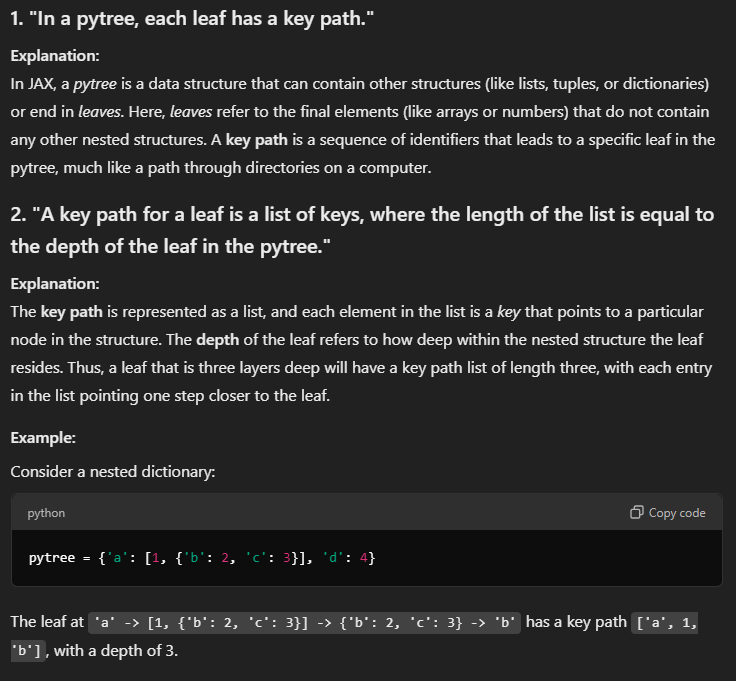

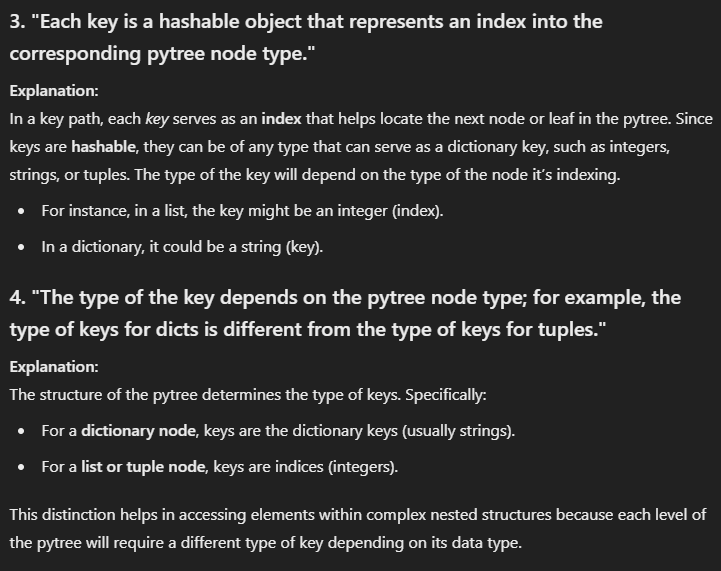

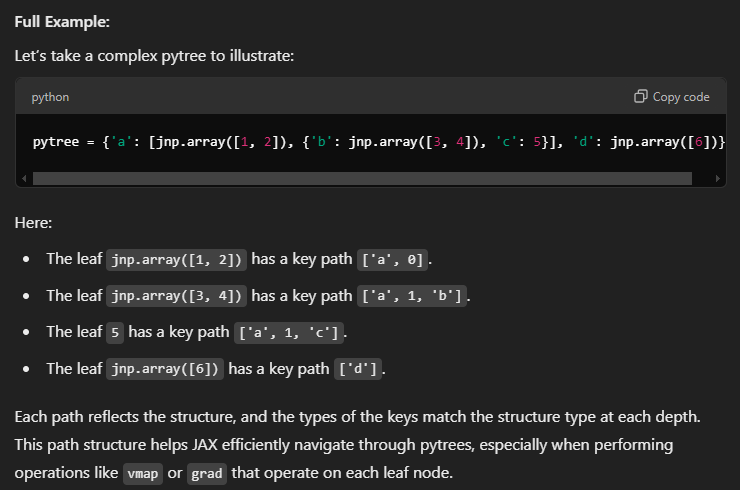

In [34]:
import collections

ATuple = collections.namedtuple("ATuple", ('name'))

tree = [1, {'k1': 2, 'k2': (3, 4)}, ATuple('foo')]
flattened, _ = jax.tree_util.tree_flatten_with_path(tree)

for key_path, value in flattened:
  print(f'Value of tree{jax.tree_util.keystr(key_path)}: {value}')

Value of tree[0]: 1
Value of tree[1]['k1']: 2
Value of tree[1]['k2'][0]: 3
Value of tree[1]['k2'][1]: 4
Value of tree[2].name: foo


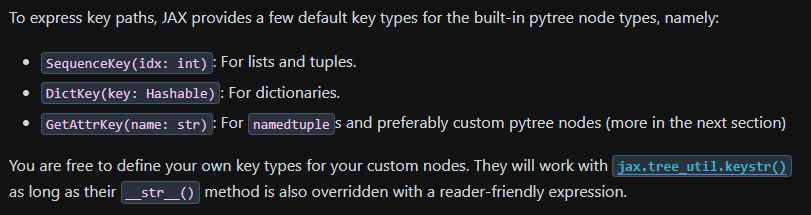

In [35]:
for key_path, _ in flattened:
  print(f'Key path of tree{jax.tree_util.keystr(key_path)}: {repr(key_path)}')

Key path of tree[0]: (SequenceKey(idx=0),)
Key path of tree[1]['k1']: (SequenceKey(idx=1), DictKey(key='k1'))
Key path of tree[1]['k2'][0]: (SequenceKey(idx=1), DictKey(key='k2'), SequenceKey(idx=0))
Key path of tree[1]['k2'][1]: (SequenceKey(idx=1), DictKey(key='k2'), SequenceKey(idx=1))
Key path of tree[2].name: (SequenceKey(idx=2), GetAttrKey(name='name'))


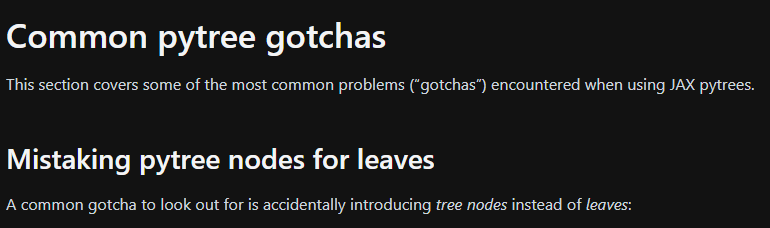

In [36]:
a_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]

# Try to make another pytree with ones instead of zeros.
shapes = jax.tree.map(lambda x: x.shape, a_tree)
jax.tree.map(jnp.ones, shapes)

[(Array([1., 1.], dtype=float32), Array([1., 1., 1.], dtype=float32)),
 (Array([1., 1., 1.], dtype=float32), Array([1., 1., 1., 1.], dtype=float32))]

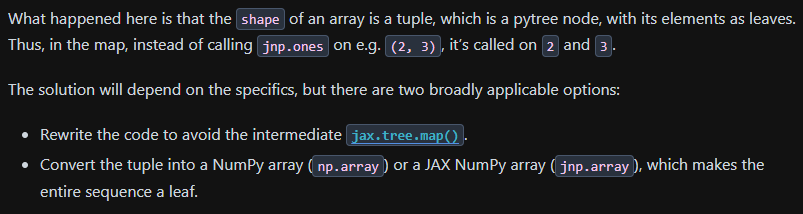

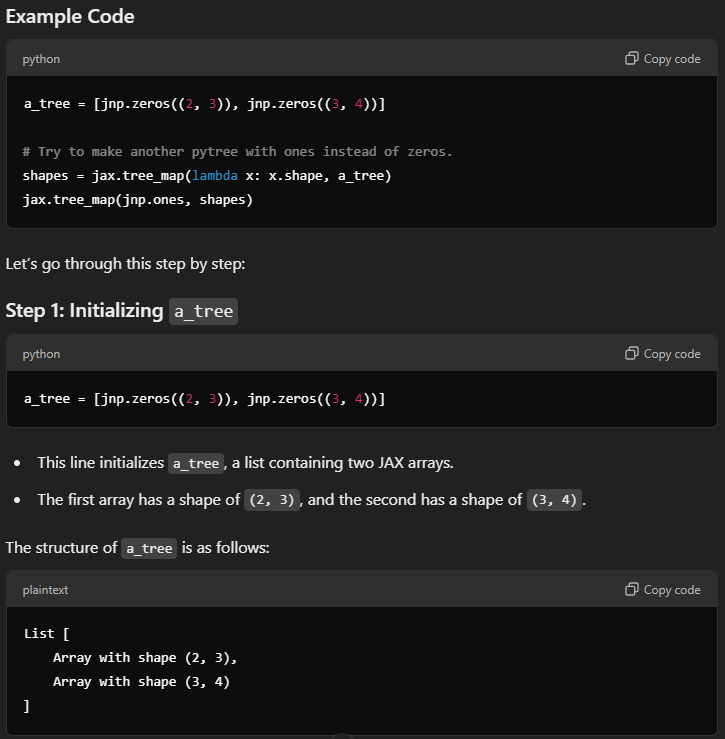

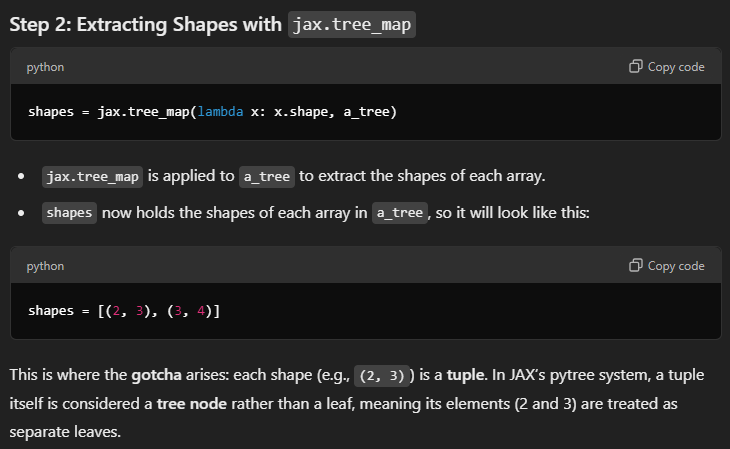

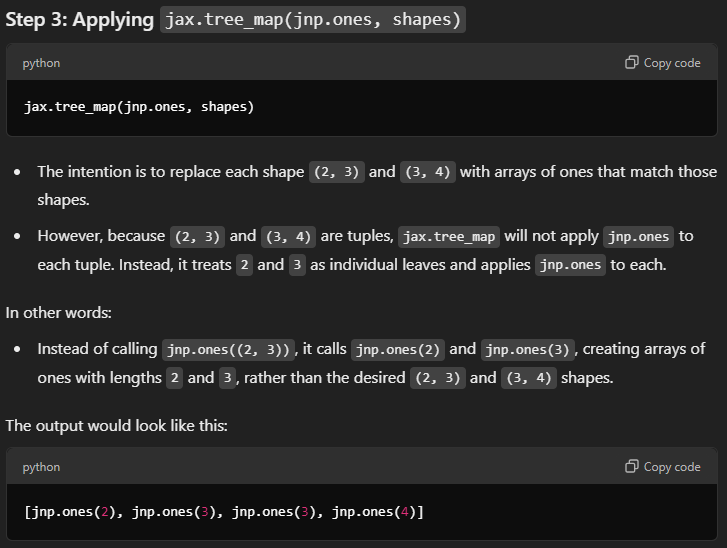

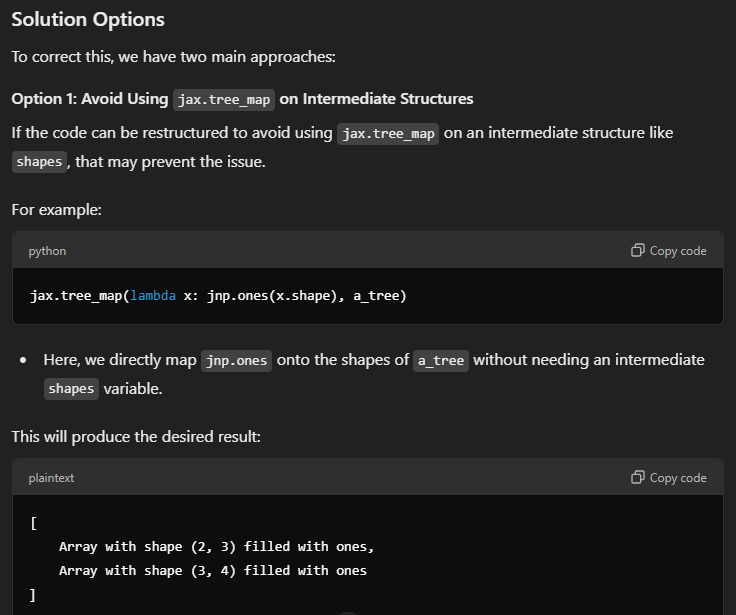

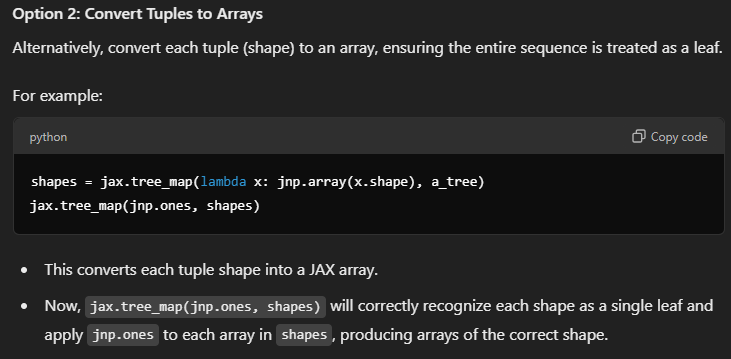

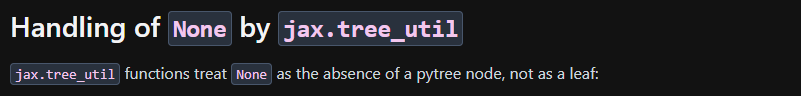

In [37]:
jax.tree.leaves([None, None, None])

[]

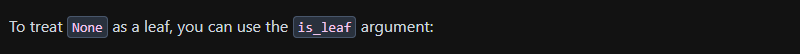

In [38]:
jax.tree.leaves([None, None, None], is_leaf=lambda x: x is None)

[None, None, None]

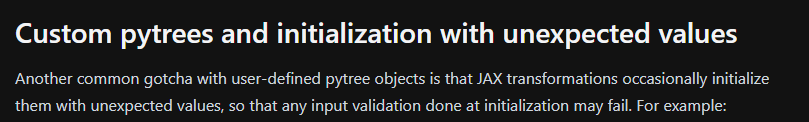

In [39]:
class MyTree:
  def __init__(self, a):
    self.a = jnp.asarray(a)

register_pytree_node(MyTree, lambda tree: ((tree.a,), None),
    lambda _, args: MyTree(*args))

tree = MyTree(jnp.arange(5.0))

jax.vmap(lambda x: x)(tree)      # Error because object() is passed to `MyTree`.

TypeError: Value '<object object at 0x000002C9277BBC50>' with dtype object is not a valid JAX array type. Only arrays of numeric types are supported by JAX.

In [40]:
jax.jacobian(lambda x: x)(tree)  # Error because MyTree(...) is passed to `MyTree`.

d:\anaconda3\Lib\site-packages\jax\_src\numpy\lax_numpy.py:3289: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order)


TypeError: Value '<object object at 0x000002C929A18860>' with dtype object is not a valid JAX array type. Only arrays of numeric types are supported by JAX.

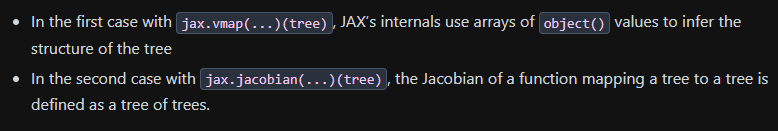

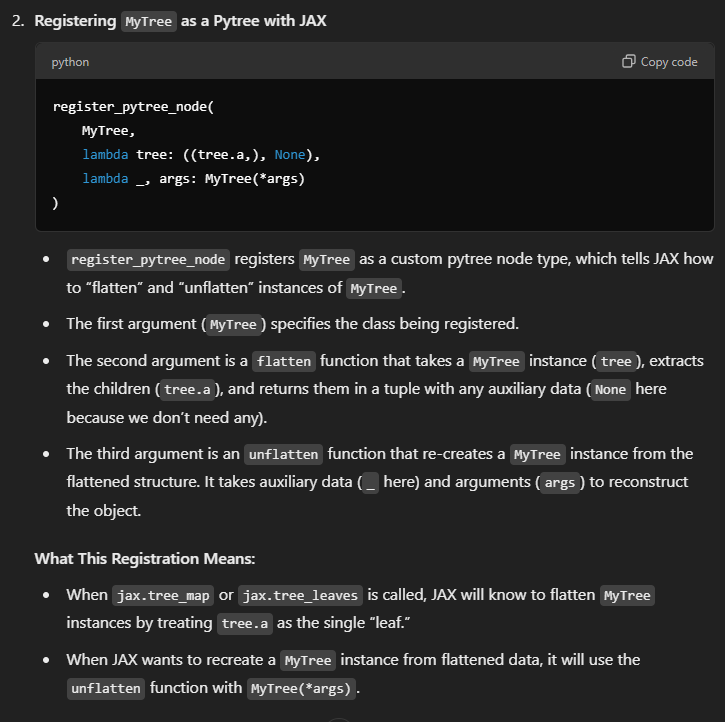

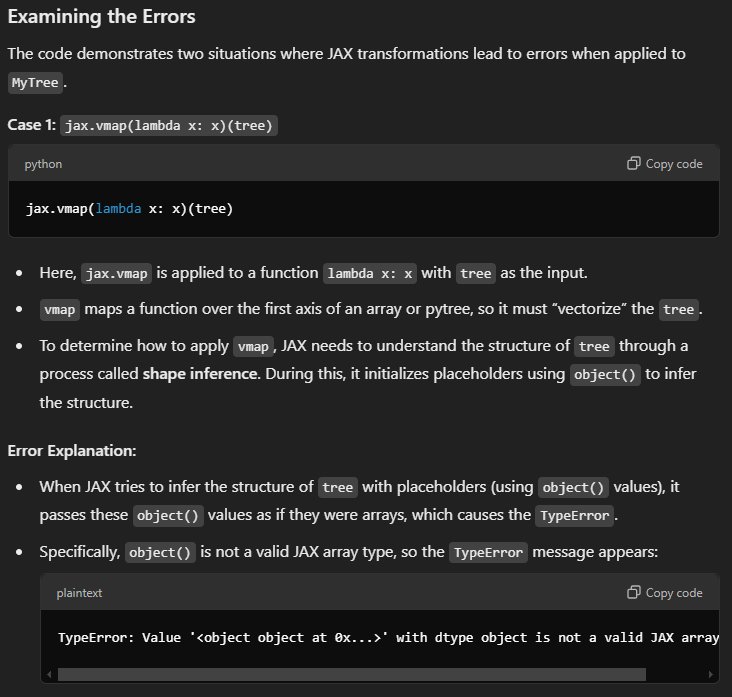

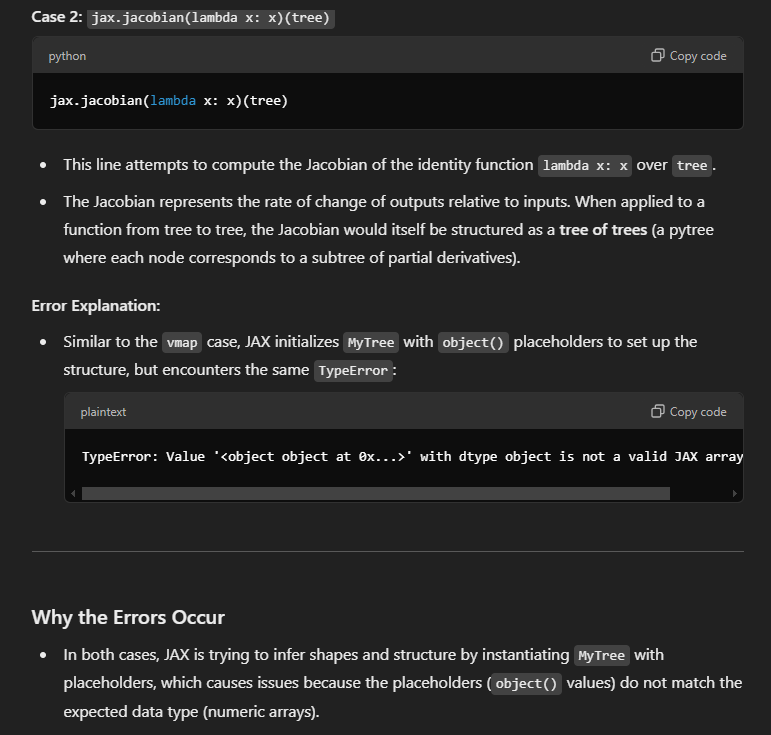

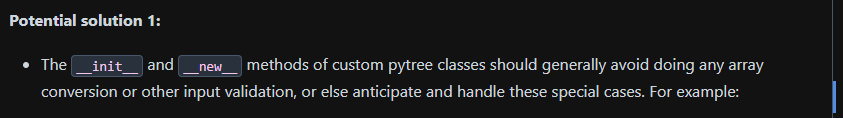

In [41]:
class MyTree:
  def __init__(self, a):
    if not (type(a) is object or a is None or isinstance(a, MyTree)):
      a = jnp.asarray(a)
    self.a = a

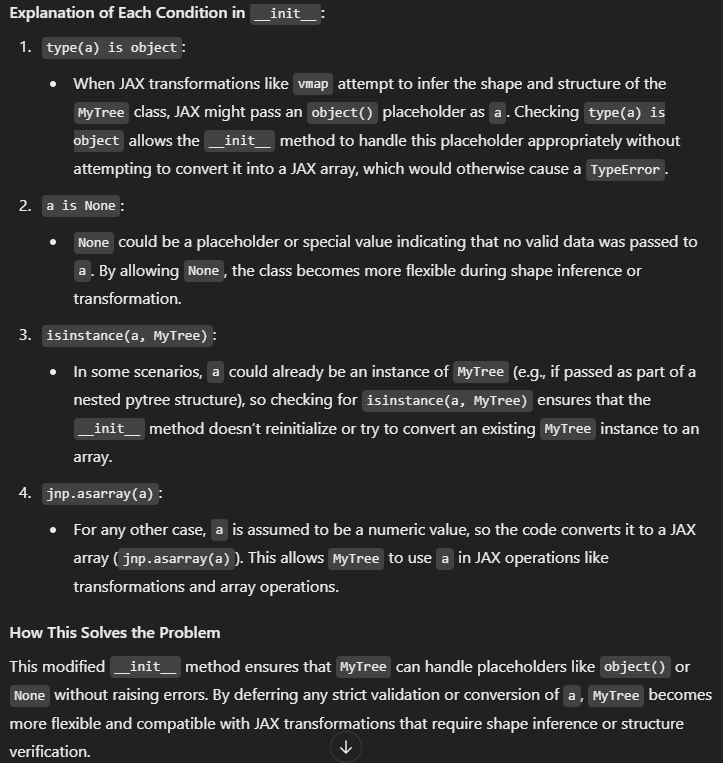

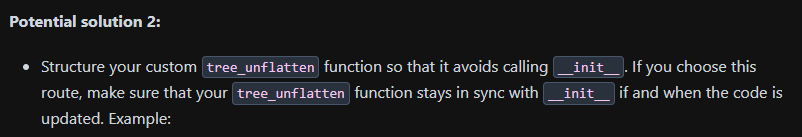

In [42]:
def tree_unflatten(aux_data, children):
  del aux_data  # Unused in this class.
  obj = object.__new__(MyTree)
  obj.a = a
  return obj

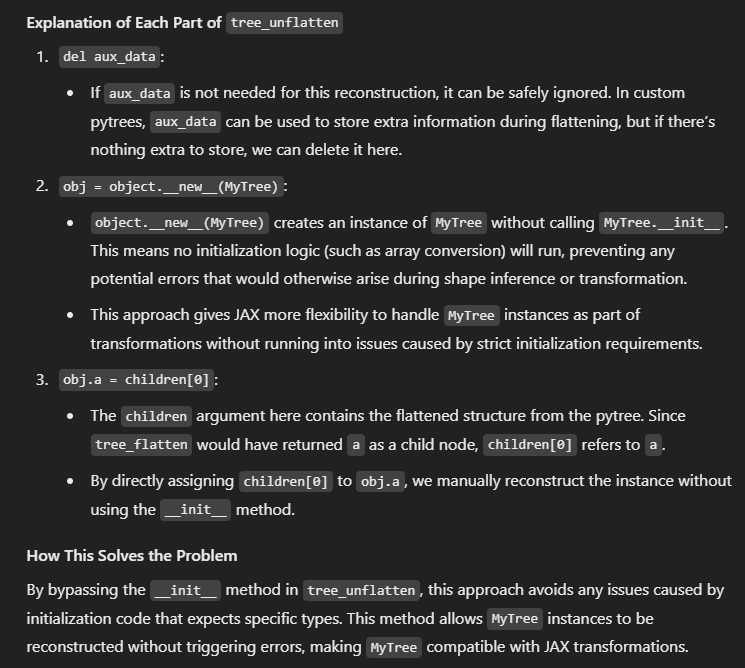

The above concepts are not very clear though

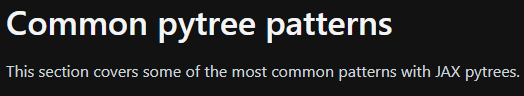

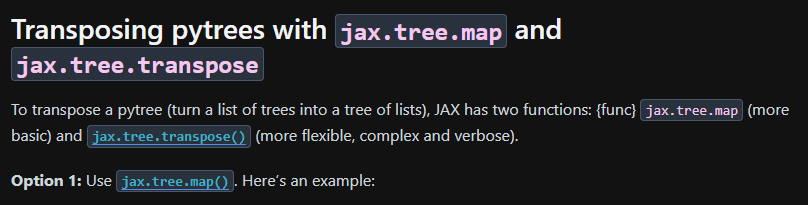

In [44]:
def tree_transpose(list_of_trees):
  """
  Converts a list of trees of identical structure into a single tree of lists.
  """
  return jax.tree.map(lambda *xs: list(xs), *list_of_trees)

# Convert a dataset from row-major to column-major.
episode_steps = [dict(t=1, obs=3), dict(t=2, obs=4)]
print(episode_steps)
tree_transpose(episode_steps)

[{'t': 1, 'obs': 3}, {'t': 2, 'obs': 4}]


{'obs': [3, 4], 't': [1, 2]}

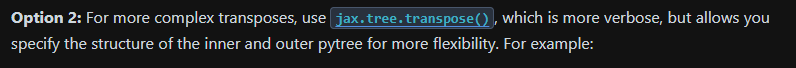

In [45]:
jax.tree.transpose(
  outer_treedef = jax.tree.structure([0 for e in episode_steps]),
  inner_treedef = jax.tree.structure(episode_steps[0]),
  pytree_to_transpose = episode_steps
)

{'obs': [3, 4], 't': [1, 2]}

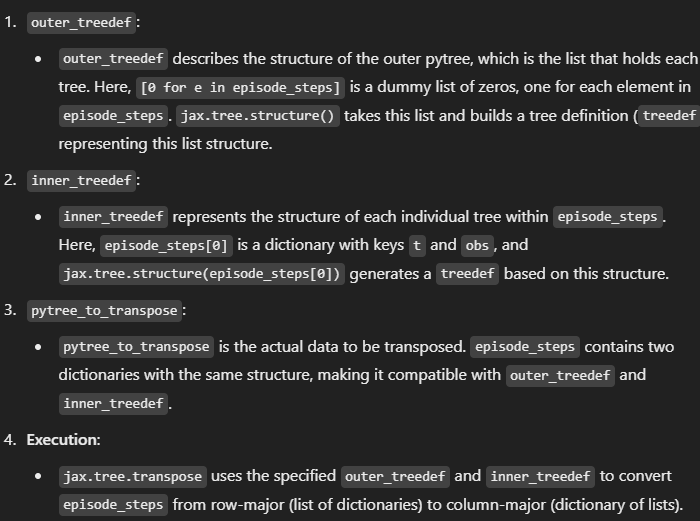

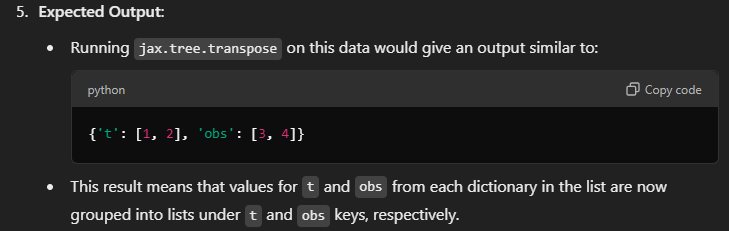

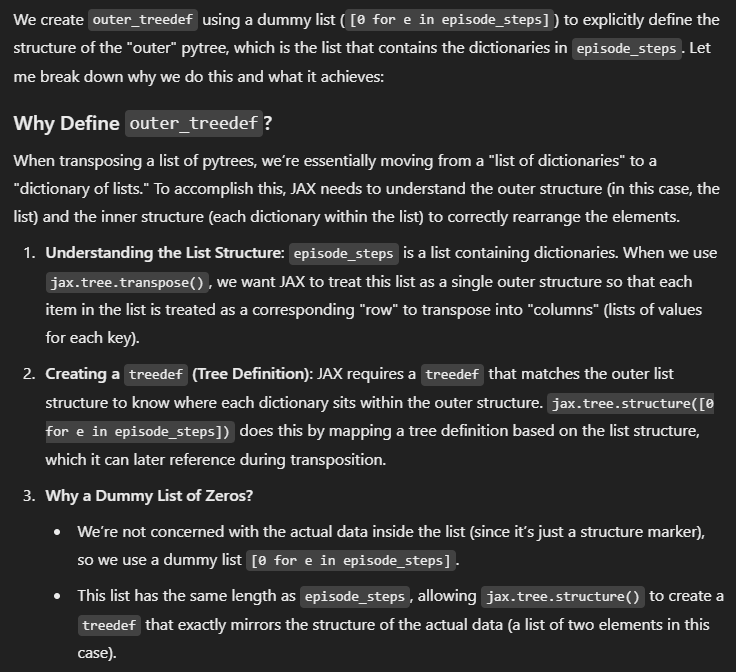

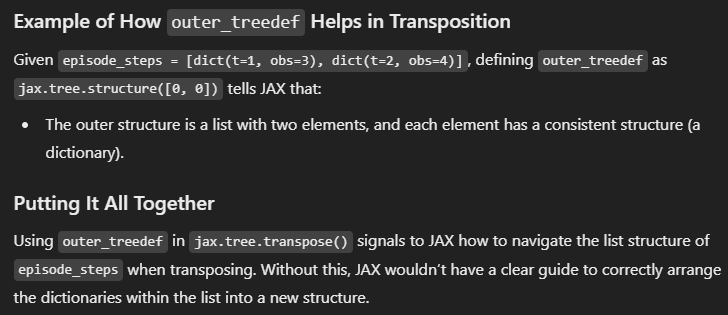